In [37]:
%matplotlib notebook
from os import chdir
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches



The data set consists of the results of votes on 16 bills that came before the House of Representatives in 1984.

We will attempt to predict the party affiliation of members of Congress based on their voting records.

This data set comes from the UCI Machine Learning Repository and is available at 
https://archive.ics.uci.edu/ml/datasets/congressional+voting+records.

In [67]:
chdir('/Users/vlos/MLProjects/Votes')


data = pd.read_csv("data/house-votes-84.data.txt", header = None)

class_labels = data[0].unique()

print(class_labels)

print(data[1].unique())

print(data.shape)


['republican' 'democrat']
['n' '?' 'y']
(435, 17)


In [40]:
##We will numerically encode the class labels as Ones and Zeros

Label_Dict = {class_labels[0]: 0, class_labels[1]: 1}

data[0] = data[0].map(Label_Dict)

##We must numerically encode the vote results as well as the missing votes (abstention), which were marked '?'

Votes_dict = {'y':1, 'n':-1, '?':0}

data.iloc[:, 1:] = data.iloc[:, 1:].applymap(lambda x: Votes_dict[x])




In [41]:
##We will shuffle the data just in case it had some sort of ordering already
data = data.sample(frac = 1.0, replace = False, axis = 0)



In [42]:
##Now we will split the data into a training set, a validation set, and a testing set

train, test = train_test_split(data, test_size = 0.15)
train, validation = train_test_split(train, test_size = 0.2)

##Now lets split off the class labels, which are contained in the first column of each DataFrame
##Then we will drop the first column from each DataFrame, separating the data and the labels

train_labels = train.iloc[:, 0].copy(deep = True)
train = train.drop([0], axis = 1)

validation_labels = validation.iloc[:, 0].copy(deep = True) 
validation = validation.drop([0], axis = 1)

test_labels = test.iloc[:, 0].copy(deep = True)
test = test.drop([0], axis = 1)







Now lets apply PCA to the training set and see what kind of visualization we can get.
We will extract the top two principal components

We will also find a line to separate the data using linear discriminant analysis. 
We will then plot it with the data
to get a feel for the linear separability of the data when using the PCA representation








In [43]:
pca = PCA(n_components = 2)

pca_train = pca.fit_transform(train)

LD = LinearDiscriminantAnalysis()
LD.fit(pca_train, train_labels)

a, b = LD.coef_[0], LD.intercept_
m = a[0]/a[1]
b = b[0]/a[1]

print(m,b)



-1.18903553989 0.987325014786


In [44]:
## f: a linear function with parameters found from linear discriminant analysis
## input: x, a real
##output: a real number f(x)

def f(x):
    return m*x + b


##vec_f: a vectorized version of f for operating on numpy arrays

vec_f = np.vectorize(f)



##now lets get some samples from the linear function for plotting
bottom = np.amin(pca_train[:, 0])
top = np.amax(pca_train[:, 0])

x_values = np.arange(bottom, top, step = 0.25)

y_values = vec_f(x_values)



<IPython.core.display.Javascript object>


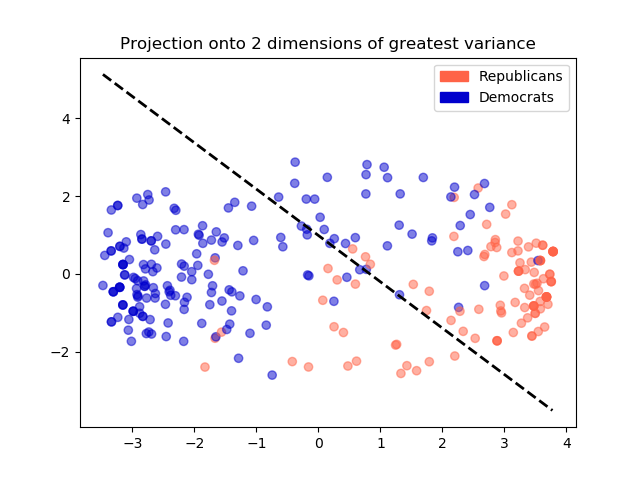

In [46]:
color_codes = {1:'mediumblue', 0:'tomato'}
c = train_labels.map(color_codes)
red_patch = mpatches.Patch(color='tomato', label='Republicans')
blue_patch = mpatches.Patch(color='mediumblue', label='Democrats')
plt.scatter(pca_train[:, 0], pca_train[:, 1], c = c, alpha = 0.5)
plt.plot(x_values, y_values, 'k--', lw = 2)
plt.legend(handles = [red_patch, blue_patch])
plt.title("Projection onto 2 dimensions of greatest variance")

Simply visually inspecting the plot, we see the line did a decent job of separating the classes. 

We should be able to do better
by taking a few more of the top principal components and using a more powerful linear classification method.

We will try using a support vector machine (SVM).


In [47]:
pca = PCA(n_components = 7)
pca_train = pca.fit_transform(train)


#lets examine how much of the variance is explained in the first 2 principal components versus
## in the top 7 principle components
var_2 = np.sum(pca.explained_variance_ratio_[:2])
var_7 = np.sum(pca.explained_variance_ratio_[:7])

print("The first 2 principal components explain %0.2f%% of the variance\n" % (100*var_2))

print("The first 7 principal components explain %0.2f%% of the variance\n" % (100*var_7))



The first 2 principal components explain 55.23% of the variance

The first 7 principal components explain 80.86% of the variance



In [52]:
##let's transform the validation set according to the pca transformation found from the training data

pca_validation = pca.transform(validation)

##Now let's train a basic svm classifier with a linear kernel on the training data
##and evaluate its performance on the validation set




svm = SVC(C = 1.0, kernel = 'linear')
svm.fit(pca_train, train_labels)
predictions = svm.predict(pca_validation)
score = accuracy_score(validation_labels, predictions, normalize = True)
print("The SVM classified %0.2f%% of the observations correctly\n" %(100*score) )



The svm  classified 90.54% of the observations correctly



The svm with a linear kernel performed very well.
It has also established a baseline of performance.

Now let's see how much additional improvement we can get from using a radial basis function (RBF) kernel
rather than a linear kernel. However, now we have a parameter we must tune, the kernel coefficient.
Thus, we will need to train a few different SVM classifiers with different values of the kernel coefficient.
Then we will evaluate how they perform on the validation set and select the best one.


In [56]:
gamma_values = [0.001, 0.01, 0.1, 0.2, 0.3, 0.5, 0.8, 1.0, 1.2]

for gamma in gamma_values:
    svm = SVC(kernel = 'rbf', gamma = gamma)
    svm.fit(pca_train, train_labels)
    predictions = svm.predict(pca_validation)
    score = accuracy_score(validation_labels, predictions, normalize = True)
    print("The SVM with gamma = %f classified %0.2f%% of the observations correctly\n" %(gamma, 100*score) )





The SVM with gamma = 0.001000 classified 91.89% of the observations correctly

The SVM with gamma = 0.010000 classified 90.54% of the observations correctly

The SVM with gamma = 0.100000 classified 94.59% of the observations correctly

The SVM with gamma = 0.200000 classified 94.59% of the observations correctly

The SVM with gamma = 0.300000 classified 94.59% of the observations correctly

The SVM with gamma = 0.500000 classified 93.24% of the observations correctly

The SVM with gamma = 0.800000 classified 93.24% of the observations correctly

The SVM with gamma = 1.000000 classified 89.19% of the observations correctly

The SVM with gamma = 1.200000 classified 86.49% of the observations correctly



The best performing model classified 3% more of the examples correctly than the SVM with linear kernel did.

Now we will train the best kernel SVM model on the combined training and validation data, then apply it to
the test data, and evaluate its performance.

In [66]:
##concatenate the data
FullTrainingData_pca = np.concatenate([pca_train, pca_validation], axis = 0)
FullTrainingLabels = np.concatenate([train_labels, validation_labels])

##Create model and train on data
svm =  SVC(kernel = 'rbf', gamma = 0.2)
svm.fit(FullTrainingData_pca, FullTrainingLabels)


##Apply PCA transform to test data
pca_test = pca.transform(test)


##make and score predictions
predictions = svm.predict(pca_test)

score = accuracy_score(test_labels, predictions, normalize = True)
raw_score = accuracy_score(test_labels, predictions, normalize = False)

print("The final model classified %0.2f%% of the examples correctly" %(100*score))
print("Out of %d examples, %d were classified correctly" %(len(test_labels), raw_score))




The final model classified 96.97% of the examples correctly
Out of 66 examples, 64 were classified correctly


And so, the final model was able to classify 96.97% of the observations correctly, or out of the 66 members of congress in the test set, we were able to correctly identify the party affiliation of 64 of them based on how they voted.

It's not surprising that we were able to achieve very high accuracy on this data given that members of congress usually vote the same way as the other members of their party.